### Test

In [40]:
print("Hello, World! ")

Hello, World! 


# Import libraries

In [64]:
import pandas as pd
import torch
#import torch_geometric 
#import torch_geometric_temporal
import numpy as np

import geopandas as gpd
from shapely.geometry import LineString
from shapely.geometry import Point
import matplotlib.pyplot as plt

import networkx as nx
from scipy.spatial.distance import euclidean

import torch
from torch_geometric.data import Data

# Check Datasets

In [2]:
FLOWDATA_PATH = r"C:\Users\ameli\Documents\Uni\year-3-notes\diss\Dataset\FlowData_for_SubsetGraph_12_with_7SensoredPipes.csv"
SUBSETGRAPH_PATH = r"C:\Users\ameli\Documents\Uni\year-3-notes\diss\Dataset\SubsetGraph_12_with_7SensoredPipes.csv"

In [43]:
df_flowdata = pd.read_csv(FLOWDATA_PATH, index_col=0)
print(df_flowdata.head())

df_subsetgraph = pd.read_csv(SUBSETGRAPH_PATH, index_col=0)
print(df_subsetgraph.head())

                      1615       919       157      1959       1016      1994  \
Time                                                                            
01-Jan-2020 00:00:00   NaN  2.811111  5.344444  0.888889  21.999999  1.888889   
01-Jan-2020 00:15:00   NaN  2.166667  5.244444  0.766667  22.544444  1.822222   
01-Jan-2020 00:30:00   NaN  2.655556  5.433334  0.855556  22.844444  1.966667   
01-Jan-2020 00:45:00   NaN  2.633333  5.355556  0.800000  22.111110  2.300000   
01-Jan-2020 01:00:00   NaN  2.533333  5.144445  0.866667  21.244444  1.944445   

                          1870  
Time                            
01-Jan-2020 00:00:00  3.555556  
01-Jan-2020 00:15:00  3.333333  
01-Jan-2020 00:30:00  3.666667  
01-Jan-2020 00:45:00  3.222222  
01-Jan-2020 01:00:00  3.222222  
       WATERNETWO  ASSET_NO DIAM_UNIT   LENGTH MATERIAL  INST_DATE  \
113651         A2  71805024        mm    9.220       DI        NaN   
113685         A2  94460832        mm  112.775       DI      

# Data Visualisation

In [44]:
# converting data to floats, and missing data to NaN
# this is so geopandas can process it
for column in ['Start_x','Start_y','End_x','End_y']:
    df_subsetgraph[column] = pd.to_numeric(df_subsetgraph[column], errors='coerce')

# create a LineString object for each pipe segment in the dataset
geometry = []
for idx, row in df_subsetgraph.iterrows():
    start_point = (row['Start_x'], row['Start_y'])
    end_point = (row['End_x'], row['End_y'])
    
    line = LineString([start_point, end_point])
    geometry.append(line)


water_network_sensors = gpd.GeoDataFrame(df_subsetgraph, geometry=geometry)

In [45]:
nodes_start = gpd.GeoDataFrame(df_subsetgraph[['NODE1_ID', 'Start_x', 'Start_y']],
                               geometry=[Point(xy) for xy in zip(df_subsetgraph['Start_x'], df_subsetgraph['Start_y'])])

nodes_end = gpd.GeoDataFrame(df_subsetgraph[['NODE2_ID', 'End_x', 'End_y']],
                             geometry=[Point(xy) for xy in zip(df_subsetgraph['End_x'], df_subsetgraph['End_y'])])

nodes = pd.concat([
    nodes_start.rename(columns={'NODE1_ID':'NODE_ID'}),
    nodes_end.rename(columns={'NODE2_ID':'NODE_ID'})
], ignore_index=True)

water_network_nodes = nodes.drop_duplicates(subset='NODE_ID')

Plotting the graphs

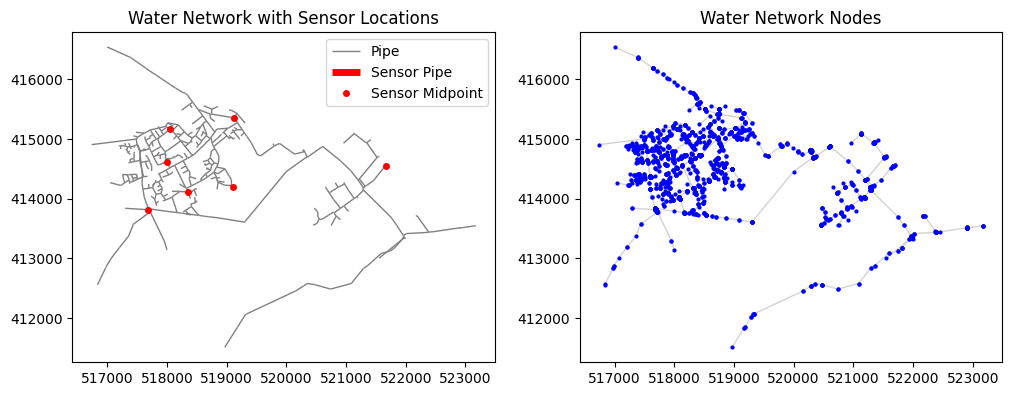

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

water_network_sensors[water_network_sensors['SensorIndicator']==0].plot(ax=ax1, color='gray', linewidth=1, zorder=1)
water_network_sensors[water_network_sensors['SensorIndicator']==1].plot(ax=ax1, color='red', linewidth=5, zorder=2)

for _, row in water_network_sensors[water_network_sensors['SensorIndicator']==1].iterrows():
    mid_x = (row['Start_x'] + row['End_x']) / 2
    mid_y = (row['Start_y'] + row['End_y']) / 2
    ax1.plot(mid_x, mid_y, 'ro', markersize=4, zorder=3)

ax1.set_title("Water Network with Sensor Locations")
ax1.legend(['Pipe','Sensor Pipe','Sensor Midpoint'])


water_network_sensors.plot(ax=ax2, color='lightgray', linewidth=1, zorder=1) 
water_network_nodes.plot(ax=ax2, color='blue', markersize=4, zorder=2)
ax2.set_title("Water Network Nodes")

plt.show()

# Load Graph Data

In [10]:
FLOWDATA_PATH = r"C:\Users\ameli\Documents\Uni\year-3-notes\diss\Dataset\FlowData_for_SubsetGraph_12_with_7SensoredPipes.csv"
SUBSETGRAPH_PATH = r"C:\Users\ameli\Documents\Uni\year-3-notes\diss\Dataset\SubsetGraph_12_with_7SensoredPipes.csv"

In [ ]:
def load_graph(file_path):
    g = nx.Graph()

    df_subsetgraph = pd.read_csv(file_path)
    df_node_items = df_subsetgraph[df_subsetgraph['SensorIndicator'] == 1]

    for i, row1 in df_node_items.iterrows():
        for j, row2 in df_node_items.iterrows():
            if row1['SensorDMA'] > row2['SensorDMA']:
                g.add_edge(row1['SensorDMA'], row2['SensorDMA'], weight=calc_edge_weight('euclidean', row1, row2))
            
    return g, df_node_items


def calc_edge_weight(technique, row1, row2):
    if technique == 'euclidean':
        return euclidean(row1[['XMid', 'YMid']], row2[['XMid', 'YMid']])
    else:
        raise ValueError(f"Unknown technique: {technique}")
    

def assign_node_indices(g):
    node_list = list(g.nodes)

    node_to_index = {}
    index_to_node = {}

    for i, node in enumerate(node_list):
        node_to_index[node] = i
        index_to_node[i] = node

    return node_to_index, index_to_node


def get_node_features(file_path):
    df = pd.read_csv(file_path, index_col=0)
    x = torch.tensor(df.values, dtype=torch.float).T
    return x

def get_edge_tensors(g, node_to_index):
    indexed_edge_start_nodes = []
    indexed_edge_end_nodes = []
    edge_weights = []

    edge_list = g.edges(data=True)

    for start_node, end_node, weight in edge_list:
        indexed_edge_start_nodes.append(node_to_index[start_node])
        indexed_edge_end_nodes.append(node_to_index[end_node])
        edge_weights.append(weight['weight'])

    edge_index = torch.tensor([indexed_edge_start_nodes, indexed_edge_end_nodes])
    edge_weight = torch.tensor(edge_weights, dtype=torch.long)
    return edge_index, edge_weight

def train_test_split():
    pass


In [62]:
g, items = load_graph(SUBSETGRAPH_PATH)

#print(items[['SensorDMA', 'XMid', 'YMid']])
#print(nx.to_pandas_adjacency(g, weight='weight'))

In [ ]:
g, items = load_graph(SUBSETGRAPH_PATH)
node_features = get_node_features(FLOWDATA_PATH)


node_to_index, index_to_node = assign_node_indices(g)
edge_index, edge_weight = get_edge_tensors(g, node_to_index)

# TODO: CHECK NODE FEATURES INDEXES CORRESPOND TO EDGE INDEXES


#print(node_features.shape)
#train_mask, test_mask = train_test_split()

#data = Data(
    #x=node_features,
    #edge_index=edge_index,
    #edge_weight=edge_weight,
    #train_mask=train_mask,
    #test_mask=test_mask
#)

tensor([[    nan,     nan,     nan,  ...,  5.0089,  4.6233,  5.0022],
        [ 2.8111,  2.1667,  2.6556,  ...,  3.4333,  2.8889,  2.4333],
        [ 5.3444,  5.2444,  5.4333,  ...,  1.7667,  1.3667,  1.5889],
        ...,
        [22.0000, 22.5444, 22.8444,  ...,  9.8667, 35.0889, 22.9889],
        [ 1.8889,  1.8222,  1.9667,  ...,  1.8256,  1.5900,  1.5144],
        [ 3.5556,  3.3333,  3.6667,  ...,  2.0000,  1.8889,  1.8889]])


AttributeError: 'NoneType' object has no attribute 'shape'